In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from google.colab import drive

In [0]:
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Minor/'

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
os.listdir(path)

['sample_train_data.csv',
 'Minor_train_data.csv',
 'train_data',
 'train_data_score',
 'Sick.csv',
 'word2vec',
 'test_table.csv',
 'MODEL',
 'MODEL_STACK',
 'MODEL_BIDIRECTIONAL',
 'test.png',
 'Minor_train_data.gsheet',
 'minor-2 data',
 'test1.png',
 'Minor Project report final.docx',
 'Minor2_model.h5',
 'Minor2_attention.h5',
 'Minor2_model_run_again.h5',
 'Minor2_attention_run_again.h5']

## **Load Dataframe**

In [0]:
train_data = pd.read_csv(path+'Sick.csv')
test_data = pd.read_csv(path+'Minor_train_data.csv',names=['index','Answer','score','Correct'])
train_data.head()

,pair_ID,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL,4.5,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT,4.7,A_entails_B,B_entails_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN
3,4,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRIAL
4,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN


## **word to numeric**

In [0]:
def preprocess(df):
  X,Y = np.append(df['sentence_A'].values,df['sentence_B'].values)[:,None],np.append(df['relatedness_score'].values,df['relatedness_score'].values)[:,None]  
  temp = np.append(df['sentence_A_original'].values,df['sentence_B_original'].values)[:,None]
  return np.append(X,temp,axis=1),Y

In [0]:
X_train,Y_train = preprocess(train_data)
X_test,Y_test = (test_data[['Answer','Correct']].values),test_data['score'].values[:,None]

In [0]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((19680, 2), (19680, 1), (138, 2), (138, 1))

In [0]:
def work(words,dat,seq_length=None):
  index1 = []
  index2 = []
  for i in dat:
    temp1 = []
    temp2 = []
    for j in i[0].split():
      temp1.append(words.index(j))
    for j in i[1].split():
      temp2.append(words.index(j))
    temp1 = np.array(temp1)
    temp2 = np.array(temp2)      
    index1.append(temp1)
    index2.append(temp2)
  
  return np.asarray(index1),np.asarray(index2)

def words_to_num(train,test,seq_length=None):
  words = []
  words += ' '
  for i in   [ s.split() for s in train[:,0] ] :
    words += i
  for i in   [ s.split() for s in train[:,1] ] :
    words += i
  for i in   [ s.split() for s in test[:,0] ] :
    words += i
  for i in   [ s.split() for s in test[:,1] ] :
    words += i
  words = list(set(words))
  
  index_train1,index_train2 = work(words,train,seq_length)
  index_test1,index_test2 = work(words,test,seq_length)
  return np.array(words),index_train1,index_train2,index_test1,index_test2

    


In [0]:
vocabs,X_train1,X_train2,X_test1,X_test2 = words_to_num(X_train,X_test)

In [0]:
print(X_test[0,1])
print(X_test2[0])
print(vocabs[X_test2[0]])

To simulate the behaviour of portions of the desired software product. 
[3304   30 3068 3168 3469 2534 3469 3068  407 3505 1380]
['To' 'simulate' 'the' 'behaviour' 'of' 'portions' 'of' 'the' 'desired'
 'software' 'product.']


In [0]:
np.where(vocabs==' ')

(array([2137]),)

In [0]:
X_train1 = tf.keras.preprocessing.sequence.pad_sequences(X_train1,padding='post',truncating='post',value=np.where(vocabs==' ')[0])
X_train2 = tf.keras.preprocessing.sequence.pad_sequences(X_train2,padding='post',truncating='post',value=np.where(vocabs==' ')[0])
X_test1 = tf.keras.preprocessing.sequence.pad_sequences(X_test1,padding='post',truncating='post',value=np.where(vocabs==' ')[0])
X_test2 = tf.keras.preprocessing.sequence.pad_sequences(X_test2,padding='post',truncating='post',value=np.where(vocabs==' ')[0])

In [0]:
X_train1.shape,X_train2.shape,X_test1.shape,X_test2.shape

((19680, 32), (19680, 25), (138, 115), (138, 23))

In [0]:
vocabs[X_train1[0]]

array(['A', 'group', 'of', 'kids', 'is', 'playing', 'in', 'a', 'yard',
       'and', 'an', 'old', 'man', 'is', 'standing', 'in', 'the',
       'background', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' '], dtype='<U23')

## **create Embedding**

In [0]:
def create_embed(vocabs):
     word2vec = Word2Vec(vocabs,size=300)
     embeddings = np.random.randn(len(vocabs),300)
     for i in range(len(vocabs)):
       if vocabs[i] in word2vec.wv.vocab:
         embeddings[i] = word2vec.wv.word_vec(vocabs[i])
     return embeddings    


In [0]:
embeddings = create_embed(vocabs)
embeddings.shape

(3848, 300)

## **model**

In [0]:
def simple_model(dt1,dt2,embeddings=embeddings,batch_size=32):
  layer2_1 = tf.keras.layers.Embedding(embeddings.shape[0],embeddings.shape[1],weights=[embeddings],batch_input_shape=[batch_size,None],trainable =False)
  
  layer2 = tf.keras.layers.LSTM(1024, return_sequences=True, recurrent_initializer='glorot_uniform',recurrent_activation='sigmoid',stateful=True)
  layer3 = tf.keras.layers.Dense(150,activation = 'sigmoid')
  layer4 = tf.keras.layers.Dense(1,activation = 'sigmoid',)
  
  layer1 = tf.keras.Input(shape=(None,),batch_size=batch_size)
  layer1_2 = tf.keras.Input(shape=(None,),batch_size=batch_size)

  out1 = layer2_1(layer1)
  out1 = layer2(out1)

  out2 = layer2_1(layer1_2)
  out2 = layer2(out2)

  out3 = tf.concat([out1,out2],axis=1)
 
  out3 = tf.keras.layers.GlobalMaxPooling1D()(out3)
  out3 = layer3(out3)
  out4 = layer4(out3)
  out4 = tf.keras.layers.Lambda(lambda x:x*5)(out4)
  return tf.keras.Model([layer1,layer1_2],[out4])




In [0]:
X_train1.dtype,X_train2.dtype,X_test1.dtype,X_test2.dtype,

(dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'))

In [0]:
model = simple_model(X_train1[:48],X_train2[:48]) 

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, None)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, None)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, None, 300)      1154400     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (32, None, 1024)     5427200     embedding[0][0]              

In [0]:
type(X_train1)

numpy.ndarray

In [0]:
X_train1.shape,X_train2.shape

((19680, 32), (19680, 25))

In [0]:
def compute_loss(y,y_hat):
  return tf.keras.losses.MSE(y,y_hat)

In [0]:
def acc1(y,y_pred):
  return 1-tf.keras.backend.mean(tf.keras.backend.abs(y-y_pred)/(y))

In [0]:
def pearson(y,y_pred):
  return (tf.keras.backend.mean(y_pred*y)-tf.keras.backend.mean(y_pred)*tf.keras.backend.mean(y))/(tf.keras.backend.std(y_pred)*tf.keras.backend.std(y))

In [0]:
model.compile('adam','mse',[acc1,pearson])

In [0]:
hist1 = model.fit([X_train1,X_train2],Y_train,batch_size=32,epochs=20  ,validation_split=0.2)

Epoch 1/20
492/492 [==============================] - 44s 89ms/step - loss: 1.0168 - acc1: 0.6699 - pearson: 0.2770 - val_loss: 0.9673 - val_acc1: 0.6698 - val_pearson: 0.2893
Epoch 2/20
492/492 [==============================] - 43s 88ms/step - loss: 0.8628 - acc1: 0.7054 - pearson: 0.4423 - val_loss: 0.7922 - val_acc1: 0.7161 - val_pearson: 0.3499
Epoch 3/20
492/492 [==============================] - 43s 87ms/step - loss: 0.7916 - acc1: 0.7251 - pearson: 0.5001 - val_loss: 0.8519 - val_acc1: 0.6963 - val_pearson: 0.3197
Epoch 4/20
492/492 [==============================] - 43s 87ms/step - loss: 0.7481 - acc1: 0.7363 - pearson: 0.5366 - val_loss: 0.8132 - val_acc1: 0.7070 - val_pearson: 0.3703
Epoch 5/20
492/492 [==============================] - 43s 87ms/step - loss: 0.7277 - acc1: 0.7421 - pearson: 0.5608 - val_loss: 0.7664 - val_acc1: 0.7228 - val_pearson: 0.3761
Epoch 6/20
492/492 [==============================] - 43s 87ms/step - loss: 0.6995 - acc1: 0.7493 - pearson: 0.5777 - va

In [0]:
def attention_model(dt1,dt2,embeddings=embeddings,batch_size=32):
  layer2_1 = tf.keras.layers.Embedding(embeddings.shape[0],embeddings.shape[1],weights=[embeddings],batch_input_shape=[batch_size,None],trainable =False)
  
  layer2 = tf.keras.layers.LSTM(1024, return_sequences=True, recurrent_initializer='glorot_uniform',recurrent_activation='sigmoid',stateful=True)
  layer3 = tf.keras.layers.Dense(150,activation = 'sigmoid')
  layer4 = tf.keras.layers.Dense(1,activation = 'sigmoid',)
  
  layer1 = tf.keras.Input(shape=(None,),batch_size=batch_size)
  layer1_2 = tf.keras.Input(shape=(None,),batch_size=batch_size)

  out1 = layer2_1(layer1)
  out1 = layer2(out1)

  out2 = layer2_1(layer1_2)
  out2 = layer2(out2)

  out3 = tf.keras.layers.Attention()([out1,out2])
  out3 = tf.keras.layers.GlobalMaxPooling1D()(out3)
  out3 = layer3(out3)
  out4 = layer4(out3)
  out4 = tf.keras.layers.Lambda(lambda x:x*5)(out4)
  return tf.keras.Model([layer1,layer1_2],[out4])




In [0]:
attention = attention_model(X_train1[:48],X_train2[:48])

In [0]:
attention.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, None)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(32, None)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (32, None, 300)      1154400     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (32, None, 1024)     5427200     embedding_1[0][0]          

In [0]:
attention.compile('adam','mse',[acc1,pearson])

In [0]:
hist2 = attention.fit([X_train1,X_train2],Y_train,batch_size=32,epochs=20,validation_split=0.2)

Epoch 1/20
492/492 [==============================] - 44s 89ms/step - loss: 1.0961 - acc1: 0.6521 - pearson: 0.0297 - val_loss: 0.9611 - val_acc1: 0.6898 - val_pearson: -0.0236
Epoch 2/20
492/492 [==============================] - 43s 87ms/step - loss: 1.0518 - acc1: 0.6591 - pearson: 0.1348 - val_loss: 0.9284 - val_acc1: 0.6912 - val_pearson: 0.0854
Epoch 3/20
492/492 [==============================] - 43s 87ms/step - loss: 1.0292 - acc1: 0.6644 - pearson: 0.2001 - val_loss: 0.9469 - val_acc1: 0.6772 - val_pearson: 0.1306
Epoch 4/20
492/492 [==============================] - 43s 87ms/step - loss: 1.0159 - acc1: 0.6671 - pearson: 0.2352 - val_loss: 0.9131 - val_acc1: 0.7034 - val_pearson: 0.1784
Epoch 5/20
492/492 [==============================] - 43s 88ms/step - loss: 0.9676 - acc1: 0.6793 - pearson: 0.3050 - val_loss: 0.8627 - val_acc1: 0.7066 - val_pearson: 0.2004
Epoch 6/20
492/492 [==============================] - 43s 88ms/step - loss: 0.9059 - acc1: 0.6959 - pearson: 0.3870 - v

In [0]:
class plotting():
  def __init__(self,mod):
    self.mod=mod
    
  def accPlot(self):
    plt.plot(self.mod.history['acc1'])
    plt.plot(self.mod.history['val_acc1'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
  def lossPlot(self):
    plt.plot(self.mod.history['loss'])
    plt.plot(self.mod.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

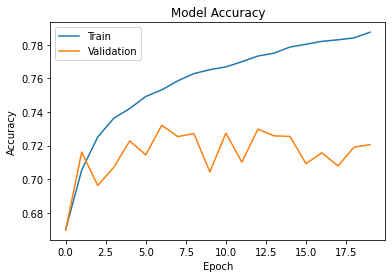

In [0]:
plots = plotting(hist1)
plots.accPlot()

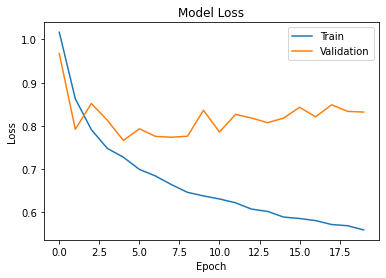

In [0]:
plots.lossPlot()

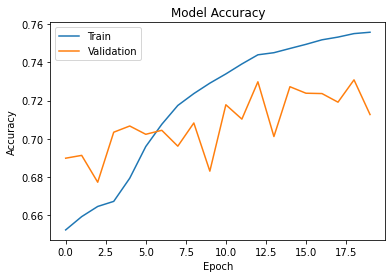

In [0]:
plots = plotting(hist2)
plots.accPlot()

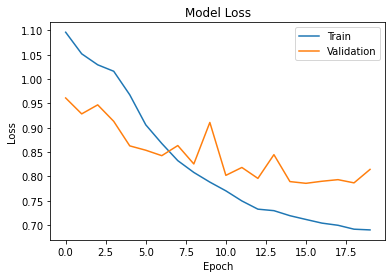

In [0]:
plots.lossPlot()

In [0]:
#model.save_weights(path+'Minor2_model.h5')

In [0]:
#attention.save_weights(path+'Minor2_attention.h5')

In [0]:
model1 = attention_model(X_train1,X_train2)

In [0]:
model1.load_weights(path+'Minor2_attention.h5')

In [0]:
model1.compile('adam','mse',[pearson])

In [0]:
acc1(Y_test[:32],model1([X_test1[:32],X_test2[:32]]).numpy()).numpy()

0.7126602578553416

In [0]:
# ATTENTION SEQ-REG
pd.DataFrame({'Answer': X_test[:32,0],'Correct Answer':X_test[:32,1],'predicted Score': np.squeeze(model1([X_test1[:32],X_test2[:32]]).numpy(),axis=1),'Actual Score': np.squeeze(Y_test[:32],axis=1) }).head()

,Answer,Correct Answer,predicted Score,Actual Score
0,High risk problems are address in the prototyp...,To simulate the behaviour of portions of the d...,3.574736,3.5
1,To simulate portions of the desired final prod...,To simulate the behaviour of portions of the d...,3.761303,5.0
2,A prototype program simulates the behaviors of...,To simulate the behaviour of portions of the d...,3.785783,4.0
3,Defined in the Specification phase a prototype...,To simulate the behaviour of portions of the d...,3.866179,5.0
4,It is used to let the users have a first idea ...,To simulate the behaviour of portions of the d...,3.711810,3.0


In [0]:
model1 =  simple_model(X_train1,X_train2)

In [0]:
model1.load_weights(path+'Minor2_model.h5')

In [0]:
model1.compile('adam','mse',[acc1])

In [0]:
acc1(Y_test[:32],model1([X_test1[:32],X_test2[:32]])).numpy()

0.6499312

In [0]:
# SIMPLE SEQ-REG 
pd.DataFrame({'Answer': X_test[:32,0],'Correct Answer':X_test[:32,1],'predicted Score': np.squeeze(model1([X_test1[:32],X_test2[:32]]).numpy(),axis=1),'Actual Score': np.squeeze(Y_test[:32],axis=1) }).head()

,Answer,Correct Answer,predicted Score,Actual Score
0,High risk problems are address in the prototyp...,To simulate the behaviour of portions of the d...,3.362483,3.5
1,To simulate portions of the desired final prod...,To simulate the behaviour of portions of the d...,3.083215,5.0
2,A prototype program simulates the behaviors of...,To simulate the behaviour of portions of the d...,3.437054,4.0
3,Defined in the Specification phase a prototype...,To simulate the behaviour of portions of the d...,3.867269,5.0
4,It is used to let the users have a first idea ...,To simulate the behaviour of portions of the d...,3.946722,3.0
